In [32]:
import numpy as np
import pandas as pd
import math

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import warnings
warnings.filterwarnings('ignore')

### Aggregated Mean Wind direction Time Series
Every sample is the average wind direction across all turbines

In [33]:
colab_path = 'ScadaData.txt'
local_path = 'C:\\Users\\hanna\\Desktop\\data\\ScadaData.txt'

scada_data = pd.read_csv(local_path, delimiter='\t',  parse_dates=True)
scada_data['dtTimeStamp'] = pd.to_datetime(scada_data['dtTimeStamp'])
average_mean_wind_directions = scada_data[['dtTimeStamp','WindDirectionMean', 'intObjectId']].groupby('dtTimeStamp').mean()[['WindDirectionMean']]

print("Number of turbines: " + str(len(scada_data['intObjectId'].unique())))
print(average_mean_wind_directions.head(5))

Number of turbines: 27
                     WindDirectionMean
dtTimeStamp                           
2019-08-01 00:00:00          63.237037
2019-08-01 00:10:00          76.285185
2019-08-01 00:20:00          87.225926
2019-08-01 00:30:00          77.285185
2019-08-01 00:40:00          70.755556


### Raw Data Plot

Text(0.5, 1.0, 'Seasonal Component')

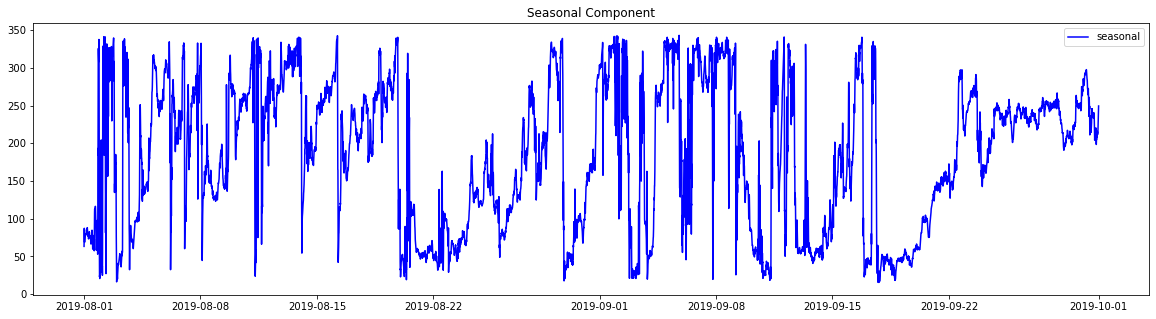

In [34]:
plt.figure(figsize=(20,5))
plt.plot(average_mean_wind_directions["WindDirectionMean"], color='blue', label='seasonal')
plt.legend(loc='best')
plt.title('Seasonal Component')

### Forecasting 1 time step
Forecasting the 10 minutes and then retraining with the real value for the forecast and repeating

In [35]:
from statsmodels.tsa.arima_model import ARIMA
import datetime as dt

X = average_mean_wind_directions[0:2000]
size = int(len(X) * 0.04)
train, test = X[0:size], X[size:len(X)]
history = train
predictions = pd.DataFrame(index=test.index, columns=['prediction'])
times = []
for i, row in test.iterrows():
    start = dt.datetime.now()
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0].flatten()[0]
    predictions.loc[i]['prediction'] = yhat
    history.loc[i] = row['WindDirectionMean']
    end = dt.datetime.now()
    times.append(end-start)
    #print('predicted=%f, expected=%f' % (predictions.loc[i]['prediction'], row['WindDirectionMean']))

print('done')
print((sum(times, dt.timedelta()) / len(times)))

done
0:00:00.047264


Text(0.5, 1.0, 'Real vs Predictions')

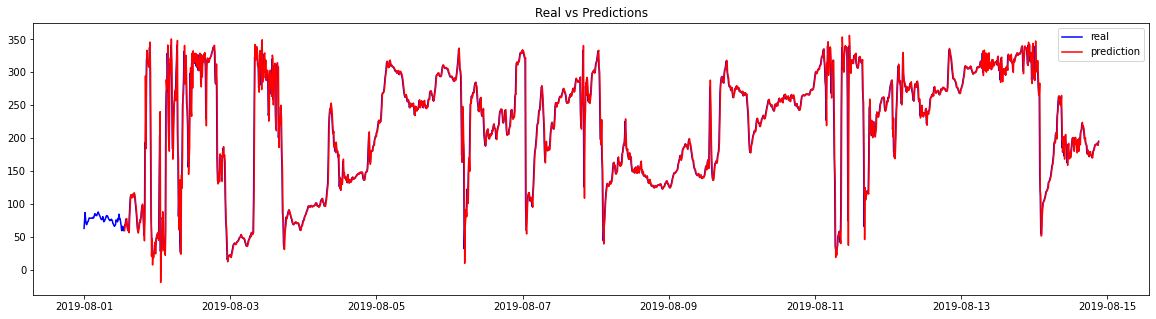

In [36]:
plt.figure(figsize=(20,5))
plt.plot(history, color='blue', label='real')
plt.plot(predictions, color='red', label='prediction')
plt.legend(loc='best')
plt.title('Real vs Predictions')

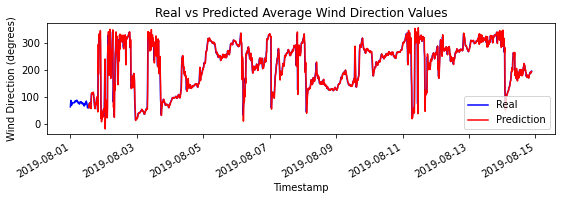

In [37]:
import matplotlib.pyplot as plt
import numpy as np

f = plt.figure(figsize=(20,5))
ax = f.add_subplot(221)
ax.plot(history, color='blue', label='Real')
ax.plot(predictions, color='red', label='Prediction')
f.autofmt_xdate()

ax.set_xlabel('Timestamp')
ax.set_ylabel('Wind Direction (degrees)')

ax.set_title('Real vs Predicted Average Wind Direction Values')
plt.legend()

plt.savefig('raw_average_wind_direction_prediction_plot.jpg')

In [38]:
combined_df = pd.concat([history,predictions], axis=1).dropna()
print(combined_df)

                     WindDirectionMean prediction
dtTimeStamp                                      
2019-08-01 13:20:00          68.396296    59.9852
2019-08-01 13:30:00          67.551852    69.5966
2019-08-01 13:40:00          75.329630    67.5202
2019-08-01 13:50:00          77.648148    76.3224
2019-08-01 14:00:00          70.459259     78.095
...                                ...        ...
2019-08-14 20:30:00         192.011111    190.723
2019-08-14 20:40:00         190.214815    192.281
2019-08-14 20:50:00         189.303704    189.993
2019-08-14 21:00:00         193.203704    189.218
2019-08-14 21:10:00         195.440741    193.859

[1920 rows x 2 columns]


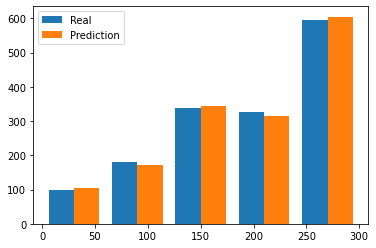

In [39]:
import random
import numpy
from matplotlib import pyplot

plt.hist([combined_df['WindDirectionMean'], combined_df['prediction']], bins=list(range(0,360, 60)), label=['Real', 'Prediction'])
plt.legend(loc='best')
plt.show()

In [40]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(combined_df['WindDirectionMean'], combined_df['prediction'])
print(error)

457.05101333097


### Forecasting 1 hour

In [41]:
from statsmodels.tsa.arima_model import ARIMA
import datetime as dt


n_step = 6
X = average_mean_wind_directions[0:2000]
size = int(len(X) * 0.04)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train.values]
predictions = list()
times = []
test_indices = [i for i in range(0, len(test.values)) if i%n_step==0]
for i in test_indices:
    start = dt.datetime.now()
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(n_step)
    yhat = output[0].flatten()
    predictions.extend(yhat)
    history.extend(test.values[i:i+n_step])
    end = dt.datetime.now()
    times.append(end-start)
    #print('predicted=%f, expected=%f' % (predictions.loc[i]['prediction'], row['WindDirectionMean']))

print('done')
print((sum(times, dt.timedelta()) / len(times)))


done
0:00:00.045633


1920


Text(0.5, 1.0, 'Real vs Predictions')

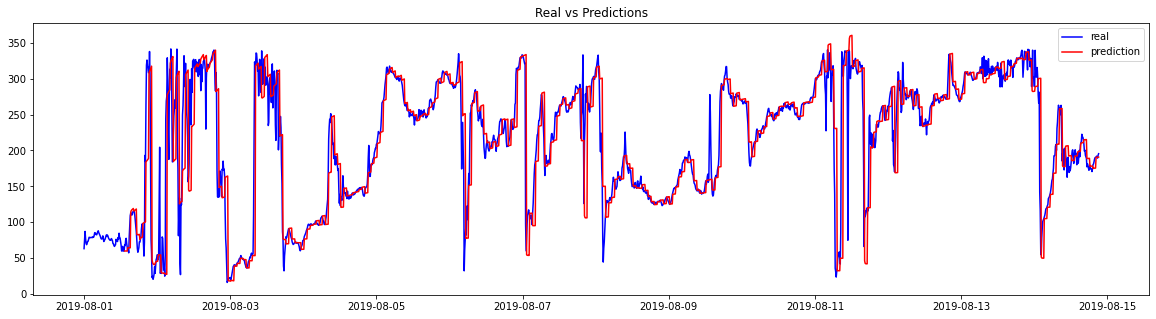

In [42]:
print(len(predictions))

predictions_df = pd.DataFrame(index=test.index, columns=['Predictions'])
predictions_df['Predictions'] = predictions

# print('done')

plt.figure(figsize=(20,5))
plt.plot(X, color='blue', label='real')
plt.plot(predictions_df, color='red', label='prediction')
plt.legend(loc='best')
plt.title('Real vs Predictions')

                     WindDirectionMean  Predictions
dtTimeStamp                                        
2019-08-01 13:20:00          68.396296    59.985194
2019-08-01 13:30:00          67.551852    59.971704
2019-08-01 13:40:00          75.329630    59.955532
2019-08-01 13:50:00          77.648148    59.939015
2019-08-01 14:00:00          70.459259    59.922454
...                                ...          ...
2019-08-14 20:30:00         192.011111   190.447832
2019-08-14 20:40:00         190.214815   190.513746
2019-08-14 20:50:00         189.303704   190.578835
2019-08-14 21:00:00         193.203704   190.643798
2019-08-14 21:10:00         195.440741   190.708742

[1920 rows x 2 columns]


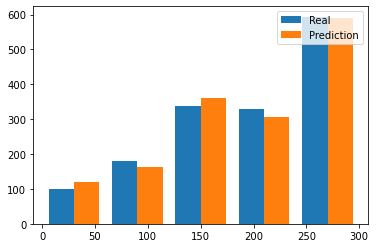

In [43]:
import random
import numpy
from matplotlib import pyplot

combined_df = pd.concat([X,predictions_df], axis=1).dropna()
print(combined_df)

plt.hist([combined_df['WindDirectionMean'], combined_df['Predictions']], bins=list(range(0,360, 60)), label=['Real', 'Prediction'])
plt.legend(loc='upper right')
plt.show()

In [44]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(combined_df['WindDirectionMean'], combined_df['Predictions'])
print('Test MSE: %.3f' % error)

Test MSE: 1771.300


In [45]:
def angle(angle1, angle2):
    a = angle1 - angle2
    a = (a + 180) % 360 - 180
    return abs(a)
    
combined_df['error'] = np.vectorize(angle)(combined_df['WindDirectionMean'], combined_df['Predictions'])
combined_df['error'] = np.square(combined_df['error'])

print(combined_df['error'].sum() / len(combined_df['error']))

1262.7646670609533
